# 康威生命游戏
改进成基于CUDA流的版本。

/home/makerlab/anaconda3/envs/pycuda/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


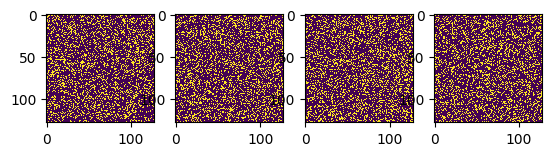

In [2]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

ker = SourceModule("""
#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )
#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )
// return the number of living neighbors for a given cell                
__device__ int nbrs(int x, int y, int * in)
{
     return ( in[ _INDEX(x -1, y+1) ] + in[ _INDEX(x-1, y) ] + in[ _INDEX(x-1, y-1) ] \
                   + in[ _INDEX(x, y+1)] + in[_INDEX(x, y - 1)] \
                   + in[ _INDEX(x+1, y+1) ] + in[ _INDEX(x+1, y) ] + in[ _INDEX(x+1, y-1) ] );
}
__global__ void conway_ker(int * lattice_out, int * lattice  )
{
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   
   // count the number of neighbors around the current cell
   int n = nbrs(x, y, lattice);
                   
    
    // if the current cell is alive, then determine if it lives or dies for the next generation.
    if ( lattice[_INDEX(x,y)] == 1)
       switch(n)
       {
          // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
          case 2:
          case 3: lattice_out[_INDEX(x,y)] = 1;
                  break;
          default: lattice_out[_INDEX(x,y)] = 0;                   
       }
    else if( lattice[_INDEX(x,y)] == 0 )
         switch(n)
         {
            // a dead cell comes to life only if it has 3 neighbors that are alive.
            case 3: lattice_out[_INDEX(x,y)] = 1;
                    break;
            default: lattice_out[_INDEX(x,y)] = 0;         
         }
         
}
""")


conway_ker = ker.get_function("conway_ker")
    
def update_gpu(frameNum, imgs, newLattices_gpu, lattices_gpu, N, streams, num_concurrent):
    for k in range(num_concurrent):
        conway_ker(newLattices_gpu[k], lattices_gpu[k], grid=(N/32,N/32,1), block=(32,32,1), stream=streams[k])
        
        imgs[k].set_data(newLattices_gpu[k].get_async(stream=streams[k]) )
        
        lattices_gpu[k].set_async(newLattices_gpu[k], stream=streams[k])
        
    return imgs
    

if __name__ == '__main__':
    # set lattice size
    N = 128

    num_concurrent = 4
    
    streams = []
    lattices_gpu = []
    newLattices_gpu = []
    
    for k in range(num_concurrent):
        streams.append(drv.Stream())
        lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
        lattices_gpu.append(gpuarray.to_gpu(lattice)) 
        newLattices_gpu.append(gpuarray.empty_like(lattices_gpu[k]))      

    fig, ax = plt.subplots(nrows=1, ncols=num_concurrent)
    imgs = []
    
    for k in range(num_concurrent):
        imgs.append( ax[k].imshow(lattices_gpu[k].get_async(stream=streams[k]), interpolation='nearest') )
    
    ani = animation.FuncAnimation(fig, update_gpu, fargs=(imgs, newLattices_gpu, lattices_gpu, N, streams, num_concurrent) , interval=0, frames=1000)    
     
    plt.show()